# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [2]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

Downloading...
From: https://drive.google.com/uc?id=1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
To: /content/x_test_night.npy
100% 58.7M/58.7M [00:00<00:00, 103MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
From (redirected): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY&confirm=t&uuid=8abc81cc-ddcf-47f6-8263-767d789787a4
To: /content/x_train_night.npy
100% 382M/382M [00:03<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
To: /content/x_val_night.npy
100% 71.4M/71.4M [00:00<00:00, 95.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
To: /content/dates_test_night.npy
100% 3.71k/3.71k [00:00<00:00, 21.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
To: /content/dates_train_night.npy
100% 23.5k/23.5k [00:00<00:00, 52.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hGg-J7ipui

In [3]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

Downloading...
From: https://drive.google.com/uc?id=1F0GGmrrGtSHizdf0COyHErNqMf9FazCK
To: /content/land_sea_mask.npy
100% 16.5k/16.5k [00:00<00:00, 55.0MB/s]


In [4]:
#a statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

Downloading...
From: https://drive.google.com/uc?id=1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ
To: /content/stat_baseline.npy
100% 48.0M/48.0M [00:00<00:00, 122MB/s]


Le us inspect and visualize data.

In [5]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

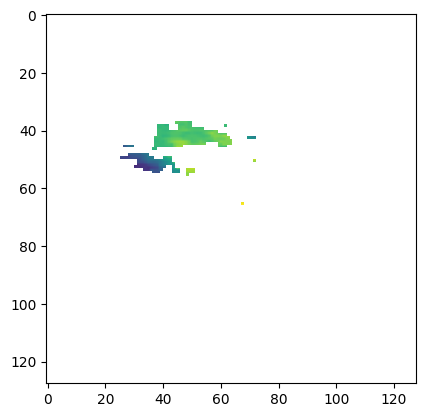

In [6]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [7]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.

1.   List item
2.   List item


In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


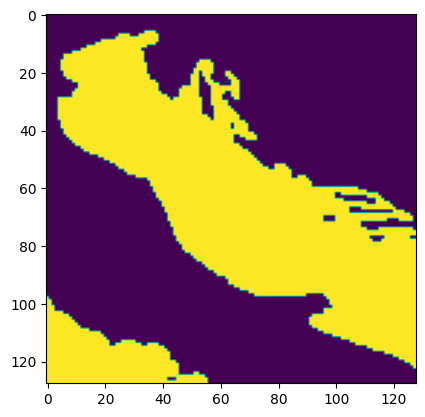

In [8]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [9]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


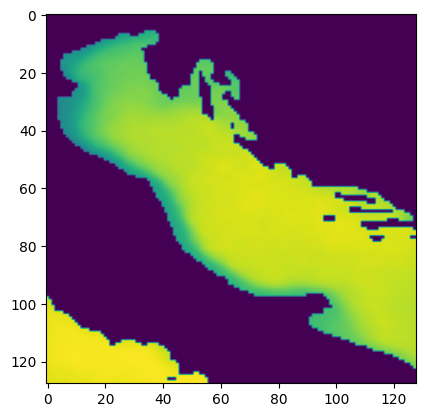

In [10]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [11]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [12]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [13]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [14]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [15]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 23.694999552653513
image 0; 0.0, 23.694999552653513
image 1; 0.0, 23.05500033071459
image 2; 0.0, 22.10858795286046


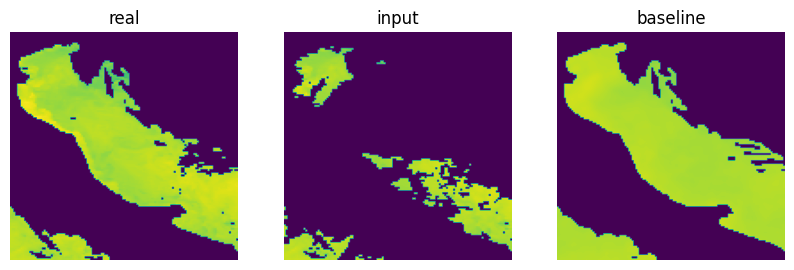

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


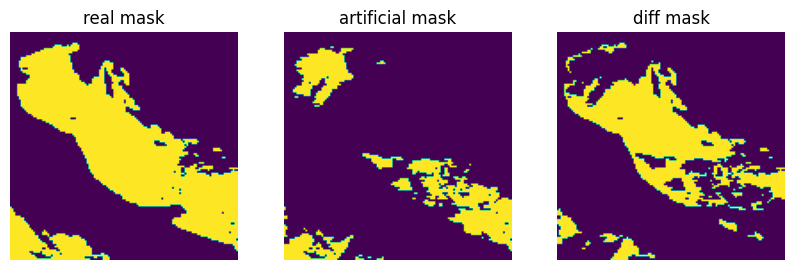

In [16]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [17]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

baseline_RMSE = RMSE

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6332421254046388
RMSE std : 0.18886826951090097


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# Step 1: Build the model
Multiple models were explored in order to complete this task. Here is a summary of most of them, or the relevant ones. Afterwards we will see the chosen model implemented

##SIMPLE CNN

This one is a simpler model to test out a few things, this model was used in order to test out a very simple and straightfoward approach, although it was more than expected that this would underperform. The values returned are significanlty slower than the ones returned previously, which are, as a reminder:

RMSE : 0.6304731512134525 //
RMSE std : 0.1822188517596936

And this model returns:

RMSE : 4.5368839145377855 //
RMSE std : 2.021708722094268

## RESNET

I tried this model because it doesn't require that many parameters, and it can be a good slution for this kind of task. Still, also this didn't provide good results and it was ultimately excluded and not further explored.

## GAN
Gan is actually the models that many research articles suggested to implement in cases similar to this, so where the task required to perform image reconstruction and inpainting. Still, GAN and especially GIN (generative inpainting network) proved to be extremely hard to implement, and required a very complicated loss function. Still, probably with more time and more research this would have proven to be the best model possible, like stated by papers such as this one:
> Kang, S.-H.; Choi, Y.; Choi, J.Y. Restoration of Missing Patterns on Satellite Infrared Sea Surface Temperature Images Due to Cloud Coverage Using Deep Generative Inpainting Network. J. Mar. Sci. Eng. 2021, 9, 310. https://doi.org/10.3390/jmse9030310




## UNET

Unet proved to be perfect for a task like this, where we are looking for masked temperature values. The following model is the one that brought the best results, and was therefore the chosen one. The most crucial part proved to be the definition of the loss function, which was able to make the model work as expected. Also, since the best results were reached after an elevated number of epochs, also early stopping was implemented in order to make sure that no unnecessary iterations were performed.

It was also found that a deeper version of UNET with more parameters performed better with respect to a more shallow version.

### Definition and compilation of the model

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom loss function
def custom_loss(y_true, y_pred):
    ground_truth = tf.expand_dims(y_true[..., 0], axis=-1)
    mask = tf.expand_dims(y_true[..., 2], axis=-1)  # 3rd channel is the mask
    diff = tf.abs(y_pred-ground_truth)
    weighted_diff = diff * mask
    return tf.reduce_mean(weighted_diff)

# Deeper U-Net model
def build_deep_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    p5 = layers.MaxPooling2D((2, 2))(c5)

    # Bottleneck
    bn = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    bn = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u5 = layers.Conv2DTranspose(1024, (3, 3), strides=(2, 2), padding='same')(bn)
    u5 = layers.concatenate([u5, c5])
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(u5)
    u4 = layers.concatenate([u4, c4])
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u4)
    u3 = layers.concatenate([u3, c3])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u3)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u2)
    u1 = layers.concatenate([u1, c1])
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    # Output layer (single-channel)
    outputs = layers.Conv2D(1, (1, 1), activation='linear', padding='same')(u1)

    # Create and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=custom_loss)
    return model

input_shape = (128, 128, 4)
#building the model
model = build_deep_unet(input_shape)

# Print model summary
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 4, 4, 1024)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 4, 4, 2048)     │     18,876,416 │ max_pooling2d_4[0][0]  │
├──────────────────────

 Total params: 138,330,113 (527.69 MB)

 Trainable params: 138,330,113 (527.69 MB)

 Non-trainable params: 0 (0.00 B)

### Training of the model

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=4,  
    min_lr=1e-6, 
    min_delta=1e-4,  
    mode='min'
)

# Definition of early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,
    verbose=1,
    restore_best_weights=True  
)

# Train the U-Net model
batch_size = 32
history = model.fit(
    train_gen,  # Training data generator
    steps_per_epoch=182,
    epochs=40,  # Total epochs
    validation_data=val_gen,  # Validation data generator
    validation_steps=50,  # Validation steps per epoch
    callbacks=[reduce_lr, early_stopping] 
)

Epoch 1/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 215s 773ms/step - loss: 0.0686 - val_loss: 0.0233 - learning_rate: 1.0000e-04
Epoch 2/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 658ms/step - loss: 0.0235 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 3/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 659ms/step - loss: 0.0226 - val_loss: 0.0213 - learning_rate: 1.0000e-04
Epoch 4/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 657ms/step - loss: 0.0223 - val_loss: 0.0213 - learning_rate: 1.0000e-04
Epoch 5/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 659ms/step - loss: 0.0225 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 6/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 661ms/step - loss: 0.0218 - val_loss: 0.0200 - learning_rate: 1.0000e-04
Epoch 7/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 658ms/step - loss: 0.0218 - val_loss: 0.0201 - learning_rate: 1.0000e-04
Epoch 8/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 120s 661ms/step - loss: 0.0211 - val_loss: 0.0192 - learning_rate: 1.0000e-04
Epoch 9/40
182/182 ━━━━━━━━━━━━━━━━━━━━ 119s 657ms/step 

# Step 2: Evaluate training and validation loss

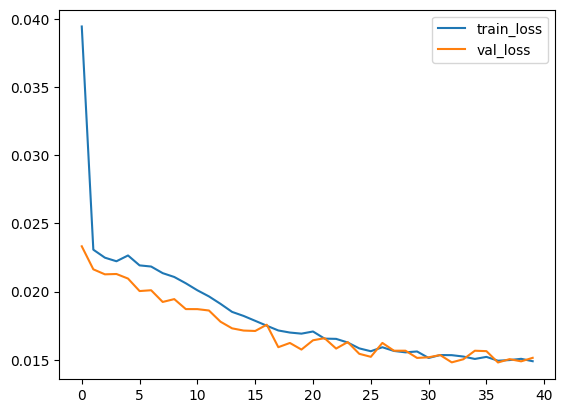

In [20]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# model.save_weights('/content/drive/MyDrive/one.weights.h5')

# Step 3: evaluate the model
This was done according to the specifications given in the task description itself.

In [29]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0)[...,0]
    #predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Remove the extra dimension from predictions_denorm using squeeze
    predictions_denorm = np.squeeze(predictions_denorm)

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.4638351050088653
RMSE std : 0.1441669064944727


# Step 4: Compare results with the baseline
In this step we notice an actual improvement of performance with the implemented neural network compared to the previously computed baseline.

In [30]:
import numpy as np
# Assuming you have already calculated RMSE for both the model and the baseline

# Print the RMSE for the model and the baseline
print("Model RMSE:", np.mean(RMSE))
print("Baseline RMSE:", np.mean(baseline_RMSE))
# Calculate and print the percentage improvement
improvement = ((np.mean(baseline_RMSE) - np.mean(RMSE)) / np.mean(baseline_RMSE)) * 100
print("Improvement over baseline: {:.2f}%".format(improvement))


Model RMSE: 0.4638351050088653
Baseline RMSE: 0.6332421254046388
Improvement over baseline: 26.75%
